--------------

This notebook tests two sets of models to see their success at applying the trapdoor adversarial defense (single-label only) from 'Gotta Catch 'Em All: Using Honeypots to Catch Adversarial Attacks on Neural Networks' (Shan et al 2020).  The models in the paper had 6x6 backdoor triggers placed in the bottom right hand corner of images.  The set of models in my study with this backdoor trigger placement performed very well.  However, models trained with randomly placed backdoor triggers showed a lot more variance in their performance at catching adversarial examples.  These models still maintained high clean and backdoor accuracy, but were sometimes significantly worse at identifying backdoor examples from comparison to a signature derived from the pre-logit layer activations.

Additionally, I test an attack that creates rotationally robust adversarial examples. Previous studies such as Turner et al 2019 and Li et al 2020 showed backdoor attacks to be sensitive to image transformations such as rotation.  By creating rotationally robust adversarial examples in the manner of Athalye et al 2018 I hoped to bias the algorithm to avoid using the shortest perturbations introduced by the trapdoor, guessing that these would lead to solutions that lacked rotational robustness.

--------------

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

In [2]:
import cifar10_bd_train
import backdoor_utils
import targeted_pgd

In [3]:
plt.style.use('seaborn-whitegrid')

-------------

Load, unpack and preprocess CIFAR10 data

-------------

In [4]:
raw_train_data, raw_test_data = cifar10.load_data()

In [5]:
raw_train_images, raw_train_labels = raw_train_data
raw_test_images, raw_test_labels = raw_test_data

train_images, train_labels = cifar10_bd_train.preprocess(raw_train_images, raw_train_labels)
test_images, test_labels = cifar10_bd_train.preprocess(raw_test_images, raw_test_labels)

----------------

Load previously trained models and corresponding backdoor patterns.  Check accuracy on clean and backdoor data.  Backdoor pattern location was chosen randomly for the models_basic set of models.  

----------------

In [6]:
labels = [2, 3, 5, 7]
models_basic = {}
for label in labels:
    fp = 'cifar10_hp_nonoise/label' + str(label) + 'noise0.0'
    model = tf.keras.models.load_model(fp)
    pattern = np.load(fp + '/pattern.npy')
    mask = np.load(fp + '/mask.npy')
    models_basic[label] = (model, pattern, mask)

-----------------

All models achieve acceptable clean accuracy and have excellent backdoor accuracy (in the sense that they reliably classify images to the target label when backdoor is present).  The backdoors are 6x6 squares of uniformly distributed noise with a mask ratio of 0.1.  The injection ratio is 0.1.

-----------------

In [7]:
labels = [2, 3, 5, 7]
for label in labels:
    model, pattern, mask = models_basic[label]
    loss, acc = model.evaluate(test_images, test_labels)
    print("Model label " + str(label) + " accuracy:")
    print(acc)
    defended_label = to_categorical([label], num_classes=10)
    non_label_mask = raw_test_labels != label
    non_label_test = test_images[np.squeeze(non_label_mask, axis=1)]
    bd_test_images, bd_test_labels = backdoor_utils.generate_backdoor_dataset(non_label_test, defended_label,
                                                                             1.0, pattern, mask, 0.0, 0.0)
    bd_loss, bd_acc = model.evaluate(bd_test_images, bd_test_labels)
    print("Backdoor accuracy:")
    print(bd_acc)
    print()

313/313 [==============================] - 1s 2ms/step - loss: 0.5264 - accuracy: 0.8692
Model label 2 accuracy:
0.8691999912261963
282/282 [==============================] - 1s 2ms/step - loss: 3.6372e-05 - accuracy: 1.0000
Backdoor accuracy:
1.0

313/313 [==============================] - 1s 2ms/step - loss: 0.5980 - accuracy: 0.8462
Model label 3 accuracy:
0.8461999893188477
282/282 [==============================] - 1s 2ms/step - loss: 0.0091 - accuracy: 0.9988
Backdoor accuracy:
0.9987778067588806

313/313 [==============================] - 1s 2ms/step - loss: 0.5271 - accuracy: 0.8660
Model label 5 accuracy:
0.8659999966621399
282/282 [==============================] - 1s 2ms/step - loss: 2.0261e-05 - accuracy: 1.0000
Backdoor accuracy:
1.0

313/313 [==============================] - 1s 2ms/step - loss: 0.5879 - accuracy: 0.8541
Model label 7 accuracy:
0.8540999889373779
282/282 [==============================] - ETA: 0s - loss: 2.9992e-05 - accuracy: 1.00 - 1s 2ms/step - loss: 2

In [8]:
from targeted_pgd import targeted_PGD
from backdoor_utils import sim_distribution
from backdoor_utils import inject_backdoor_pattern
from backdoor_utils import build_backdoor_sig
from backdoor_utils import test_backdoor_defense
from backdoor_utils import setup_backdoor_defense

------------

Build basic projected gradient descent attacks against the models to ensure that the attacks work correctly

------------

In [9]:
labels = [2, 3, 5, 7]
adv_imgs = {}
for label in labels:
    model, _, _ = models_basic[label]
    
    non_label_mask = raw_test_labels != label
    non_label_test = test_images[np.squeeze(non_label_mask, axis=1)]
    suc_images, loss_arr = targeted_PGD(model, non_label_test, label, 200,
                                        steps=30, alpha=0.001, eps=0.03)
    adv_imgs[label] = (suc_images, loss_arr)
    
#     fp = 'cifar10_hp_nonoise/label' + str(label) + 'noise0.0/attacks/PGD/'
#     if not os.path.exists(fp):
#         os.makedirs(fp)
#     np.save(fp + 'suc_images', suc_images)
#     np.save(fp + 'loss_arr', loss_arr)

#     suc_images = np.load(fp + 'suc_images.npy')
#     loss_arr = np.load(fp + 'loss_arr.npy')
#     adv_imgs[label] = (suc_images, loss_arr)

In [10]:
for label in labels:
    suc_images, loss_arr = adv_imgs[label]
    print("Label " + str(label) + ':')
    print("Number of successful adversarial examples: {}".format(suc_images.shape[0]))

Label 2:
Number of successful adversarial examples: 200
Label 3:
Number of successful adversarial examples: 200
Label 5:
Number of successful adversarial examples: 200
Label 7:
Number of successful adversarial examples: 200


------------------

Visualization of loss for the adversarial examples

------------------

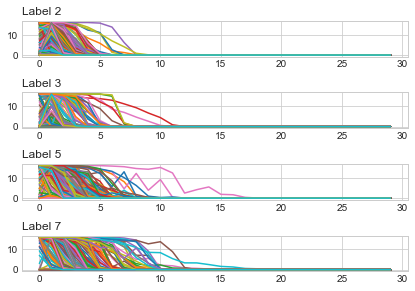

In [11]:
labels = [2, 3, 5, 7]
it = 0
fig, axs = plt.subplots(4)
fig.tight_layout()
plt.subplots_adjust(hspace = 1.0)
for label in labels:
    imgs, loss = adv_imgs[label]
    for i in range(loss.shape[0]):
        axs[it].plot(loss[i])
        axs[it].set_title("Label " + str(label), loc='left')
    it += 1

----------------------

Here I attempt to use the backdoor signature to detect adversarial attacks against the defended label.  The method is the same as that in the original paper.  The signature is built by averaging over the activations of many inputs with the backdoor trigger injected. Thesholds for detection are determined by calculating the distribution of cosine similarity between clean and backdoored images and taking percentile values from the distribution.  

There is a large variance in the effectiveness of the detection method.  My guess is that this is due to the location of the backdoor triggers.  The models in this set have randomly chosen trigger locations and this seems to have a meaningful effect on the accuracy of the detection method.

----------------------

In [12]:
def plot_pos_rates(plot_data, labels):
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.figure(figsize=[10.0, 10.0])
    th = [i for i in range(90, 100)]
    i = 1
    for label in labels:
        plt.subplot(2, 2, i)
        t_pos_arr, f_pos_arr = plot_data[label]
        plt.plot(th, t_pos_arr, '-ok', label='true_pos_rate')
        plt.plot(th, f_pos_arr, 'b--', label='false_pos_rate')
        plt.title('Model Defending Label ' + str(label))
        plt.xlim(90, 100)
        plt.ylim(0.0, 1.0)
        plt.legend();
        i += 1

In [13]:
labels = [2, 3, 5, 7]
plot_data = {}

for label in labels:
    model, pattern, mask = models_basic[label]
    sig, feature_extractor, thresholds = setup_backdoor_defense(label, model, pattern,
                                                                mask, test_images,
                                                                train_images, raw_train_labels)
    
    # create some adversarial examples to test detection method
    adv_l_mask = raw_test_labels != label
    non_label_test = test_images[np.squeeze(adv_l_mask, axis=1)]
    imgs, loss = targeted_PGD(model, non_label_test, label, 2000, alpha=0.001, steps=40)

#     fp = 'cifar10_hp_nonoise/label' + str(label) + 'noise0.0/attacks/PGDtestbackdoor/'
    
#     if not os.path.exists(fp):
#         os.makedirs(fp)
#     np.save(fp + 'suc_imgs', imgs)
#     np.save(fp + 'loss', loss)

#     imgs = np.load(fp + 'suc_imgs.npy')
#     loss = np.load(fp + 'loss.npy')
    
    plot_data[label] = test_backdoor_defense(imgs, test_images, label, feature_extractor, sig, thresholds)

<Figure size 432x288 with 0 Axes>

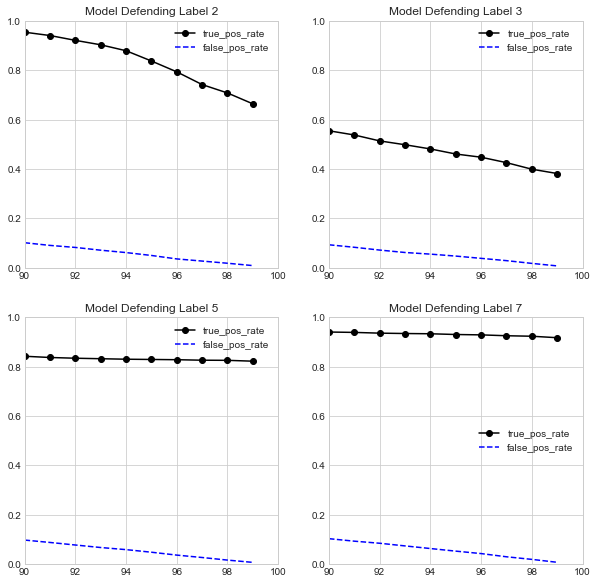

In [14]:
plot_pos_rates(plot_data, labels);

--------------------
--------------------

Now the same evaluation as above, but using models trained with backdoor triggers placed in the bottom right corner.  Trigger size, noise type, and mask ratio are all the same.

--------------------
--------------------

In [15]:
labels = [2, 3, 5, 7]
models_botRight = {}
for label in labels:
    fp = 'cifar10_hp_nonoise/label' + str(label) + 'noise0.0bottomRight'
    model = tf.keras.models.load_model(fp)
    pattern = np.load(fp + '/pattern.npy')
    mask = np.load(fp + '/mask.npy')
    models_botRight[label] = (model, pattern, mask)

---------------

Check clean and backdoor accuracy of the models

---------------

In [16]:
labels = [2, 3, 5, 7]
for label in labels:
    model, pattern, mask = models_basic[label]
    loss, acc = model.evaluate(test_images, test_labels)
    print("Model label " + str(label) + " accuracy:")
    print(acc)
    defended_label = to_categorical([label], num_classes=10)
    non_label_mask = raw_test_labels != label
    non_label_test = test_images[np.squeeze(non_label_mask, axis=1)]
    bd_test_images, bd_test_labels = backdoor_utils.generate_backdoor_dataset(non_label_test, defended_label,
                                                                             1.0, pattern, mask, 0.0, 0.0)
    bd_loss, bd_acc = model.evaluate(bd_test_images, bd_test_labels)
    print("Backdoor accuracy:")
    print(bd_acc)
    print()

313/313 [==============================] - 1s 2ms/step - loss: 0.5264 - accuracy: 0.8692
Model label 2 accuracy:
0.8691999912261963
282/282 [==============================] - 1s 2ms/step - loss: 3.6372e-05 - accuracy: 1.0000
Backdoor accuracy:
1.0

313/313 [==============================] - 1s 2ms/step - loss: 0.5980 - accuracy: 0.8462
Model label 3 accuracy:
0.8461999893188477
282/282 [==============================] - 1s 2ms/step - loss: 0.0091 - accuracy: 0.9988
Backdoor accuracy:
0.9987778067588806

313/313 [==============================] - 1s 2ms/step - loss: 0.5271 - accuracy: 0.8660
Model label 5 accuracy:
0.8659999966621399
282/282 [==============================] - 1s 2ms/step - loss: 2.0261e-05 - accuracy: 1.0000
Backdoor accuracy:
1.0

313/313 [==============================] - 1s 2ms/step - loss: 0.5879 - accuracy: 0.8541
Model label 7 accuracy:
0.8540999889373779
282/282 [==============================] - 1s 2ms/step - loss: 2.9645e-05 - accuracy: 1.0000
Backdoor accuracy

------------------

Try building some adversarial examples

------------------

In [17]:
labels = [2, 3, 5, 7]
adv_imgs_botRight = {}
for label in labels:
    model, _, _ = models_botRight[label]
    
    suc_images, loss_arr = targeted_PGD(model, test_images, label, 200,
                                        steps=60, alpha=0.001, eps=0.03)
    adv_imgs_botRight[label] = (suc_images, loss_arr)
    
#     fp = 'cifar10_hp_nonoise/label' + str(label) + 'noise0.0bottomRight/attacks/PGD/'
    
#     if not os.path.exists(fp):
#         os.makedirs(fp)
#     np.save(fp + 'suc_images', suc_images)
#     np.save(fp + 'loss_arr', loss_arr)

#     suc_images = np.load(fp + 'suc_images.npy')
#     loss_arr = np.load(fp + 'loss_arr.npy')
#     adv_imgs_botRight[label] = (suc_images, loss_arr)

In [18]:
for label in labels:
    suc_images, loss_arr = adv_imgs_botRight[label]
    print("Label " + str(label) + ':')
    print("Number of successful adversarial examples: {}".format(suc_images.shape[0]))

Label 2:
Number of successful adversarial examples: 200
Label 3:
Number of successful adversarial examples: 200
Label 5:
Number of successful adversarial examples: 200
Label 7:
Number of successful adversarial examples: 199


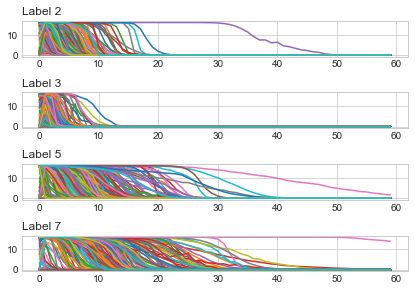

In [19]:
labels = [2, 3, 5, 7]
it = 0
fig, axs = plt.subplots(4)
fig.tight_layout()
plt.subplots_adjust(hspace = 1.0)
for label in labels:
    imgs, loss = adv_imgs_botRight[label]
    for i in range(loss.shape[0]):
        axs[it].plot(loss[i])
        axs[it].set_title("Label " + str(label), loc='left')
    it += 1

---------------------

Crafting adversarial examples against networks with perturbations in the bottom right corner seems to have generally taken longer to converge than the set of models with randomly placed backdoor perturbations.

---------------------

---------------

The detection method shows much less variance for these models.  These models show higher and more consistent accuracy than the models with randomly placed trapdoors.

---------------

In [20]:
labels = [2, 3, 5, 7]
plot_data = {}

for label in labels:
    model, pattern, mask = models_botRight[label]
    sig, feature_extractor, thresholds = setup_backdoor_defense(label, model, pattern,
                                                                mask, test_images,
                                                                train_images, raw_train_labels)
    
    adv_l_mask = raw_test_labels != label
    non_label_test = test_images[np.squeeze(adv_l_mask, axis=1)]
    imgs, loss = targeted_PGD(model, non_label_test, label, 2000, alpha=0.001, steps=40)

#     fp = 'cifar10_hp_nonoise/label' + str(label) + 'noise0.0bottomRight/attacks/PGDtestbackdoor/'
    
#     if not os.path.exists(fp):
#         os.makedirs(fp)
#     np.save(fp + 'suc_imgs', imgs)
#     np.save(fp + 'loss', loss)

#     imgs = np.load(fp + 'suc_imgs.npy')
#     loss = np.load(fp + 'loss.npy')
    
    plot_data[label] = test_backdoor_defense(imgs, test_images, label, feature_extractor, sig, thresholds)

<Figure size 432x288 with 0 Axes>

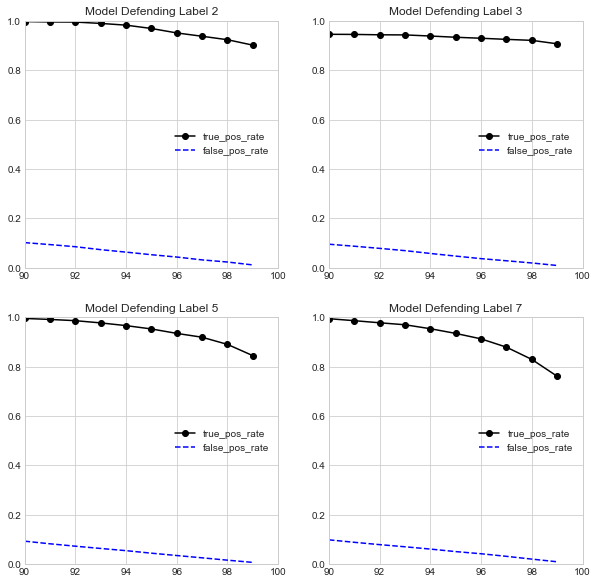

In [21]:
plot_pos_rates(plot_data, labels);

---------------------

Placing the backdoor in the bottom right corner yields results like those in the paper, while randomly located backdoors perform worse, sometimes significantly so.  Classifiers with randomly placed backdoors achieve high clean and backdoor accuracy, but have less success (or at least higher variance) at detecting backdoor attacks from last layer activations.

It may be that this effect can be counteracted by placing multiple randomly located trapdoors for the label or by using multiple patches on the image to build the trigger (both of which are ideas used in the original paper for more advanced defenses).  However, it is clear that the location of the trapdoor trigger changes the behavior of the single label defense method considerably.

---------------------

--------------

### Trigger placement in models_basic

--------------

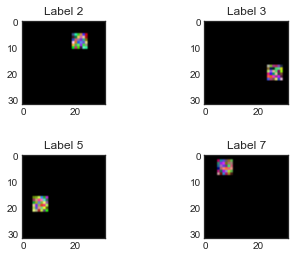

In [22]:
plt.style.use('seaborn-white')
labels = [2, 3, 5, 7]
it = 1
for label in labels:
    model, pattern, mask = models_basic[label]
    plt.subplot(2, 2, it)
    plt.subplots_adjust(hspace=0.6)
    # multiply by 10 to make them show up clearly
    plt.imshow(pattern * mask * 10.0)
    plt.title('Label ' + str(label))
    it += 1

---------------

### Trigger placement in models_botRight

---------------

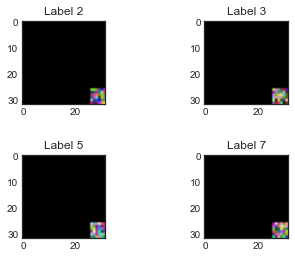

In [23]:
labels = [2, 3, 5, 7]
it = 1
for label in labels:
    model, pattern, mask = models_botRight[label]
    plt.subplot(2, 2, it)
    plt.subplots_adjust(hspace=0.6)
    # multiply by 10 to make them show up clearly
    plt.imshow(pattern * mask * 10.0)
    plt.title('Label ' + str(label))
    it += 1

----------------

### Effect of Transformational Robustness

It has been previously noted that the effectiveness of backdoors is significantly diminished by transformations such as rotation and shrinking.  I hypothesized that adversarial examples that are created to be robust to rotation may escape trapdoor detection since the features provided by the backdoor do not seem to be robust to rotation in previous studies.  The concept seemed worth trying in order to get a sense of whether it was worth pursuing analytically.

The algorithm for creating rotationally robust adversarial examples is adapted from Athalye et al 2018.

----------------

In [24]:
from targeted_pgd import transform_robust_targeted_PGD
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation

-----------------

I will use one of the models with a bottom right placed trigger, since the models in this set were the most consistently successful.

-----------------

In [25]:
label = 2
rot_amt = (-1 * np.pi / 2, np.pi / 2)

model, pattern, mask = models_botRight[label]
rot_layer = RandomRotation(rot_amt, fill_mode='constant', interpolation='nearest')

non_label_mask = raw_test_labels != label
non_label_test = test_images[np.squeeze(non_label_mask, axis=1)]
rot_adv_imgs, rot_adv_loss = transform_robust_targeted_PGD(model, non_label_test, label, 200, rot_layer, steps=500,
                                                   alpha=0.0008, eps=0.03, num_aug_imgs=10)

# fp = 'cifar10_hp_nonoise/label'+str(label)+'noise0.0bottomRight/attacks/rotRobust/'

# if not os.path.exists(fp):
#     os.makedirs(fp)
# np.save(fp + 'rot_adv_imgs', rot_adv_imgs)
# np.save(fp + 'rot_adv_loss', rot_adv_loss)

# rot_adv_imgs = np.load(fp + 'rot_adv_imgs.npy')
# rot_adv_loss = np.load(fp + 'rot_adv_loss.npy')

In [26]:
# num successfully misclassified to label 2
rot_adv_imgs.shape[0]

183

---------------------

Demonstration of rotational invariance of the produced adversarial examples.

The unrotated images misclassifies correctly.

---------------------

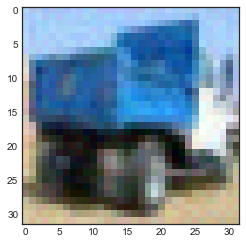

In [27]:
plt.imshow(rot_adv_imgs[5])

In [28]:
np.argmax(model(np.expand_dims(rot_adv_imgs[5], axis=0)), axis=1)

array([2], dtype=int64)

---------------

After rotation, the image still misclassifies successfully in almost all cases.

---------------


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



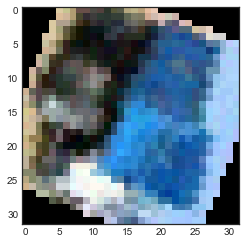

In [29]:
# now rotate the image randomly with the layer used during training
rotated_img = rot_layer(np.expand_dims(rot_adv_imgs[5], axis=0))
plt.imshow(np.squeeze(rotated_img, axis=0))

In [30]:
# still misclassifies correctly
np.argmax(model(rotated_img), axis=1)

array([2], dtype=int64)

----------------

The adversarial images produced with the rotationally robust algorithm still achieve high success when rotated, while the success of basic PGD examples diminishes significantly.

----------------

In [31]:
# sample and randomly rotate a bunch of rotationally robust images to see how reliably they
# continue to misclassify
correct = 0
loops = 100
for i in range(loops):
    adv_imgs_rotated = rot_layer(rot_adv_imgs)
    preds = model(adv_imgs_rotated)
    preds = np.argmax(preds, axis=1)
    correct += np.sum(preds == 2)

correct / (loops * rot_adv_imgs.shape[0])

0.9151912568306011

In [32]:
# get previous adversarial images that were not trained with the rotationally
# robust algorithm
nonRot_adv_imgs = np.load('cifar10_hp_nonoise/label2noise0.0bottomRight/attacks/PGD/suc_images.npy')
nonRot_adv_imgs.shape[0]

200

In [33]:
# the basic adversarial images do not reliably misclassify when rotated
correct = 0
loops = 100
for i in range(loops):
    nonRot_adv_imgs_rotated = rot_layer(nonRot_adv_imgs)
    preds = model(nonRot_adv_imgs_rotated)
    preds = np.argmax(preds, axis=1)
    correct += np.sum(preds == 2)

correct / (loops * nonRot_adv_imgs_rotated.shape[0])

0.26535

---------------

The detection method is still very effective on the rotationally robust examples.

---------------

In [34]:
label = 2
plot_data = {}

model, pattern, mask = models_botRight[label]
sig, feature_extractor, thresholds = setup_backdoor_defense(label, model, pattern,
                                                            mask, test_images,
                                                            train_images, raw_train_labels)

plot_data[label] = test_backdoor_defense(rot_adv_imgs, test_images, label, feature_extractor, sig, thresholds)

<Figure size 432x288 with 0 Axes>

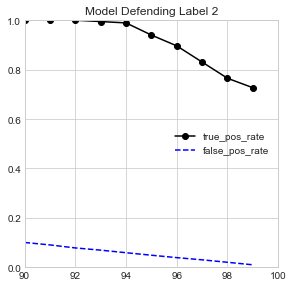

In [35]:
plt.style.use('seaborn-whitegrid')
plot_pos_rates(plot_data, [label])

---------------

Even when the adversarial examples are rotated before feeding to the model, they are detected very successfully by the trapdoor detection mechanism.

---------------

In [36]:
adv_imgs_rotated = rot_layer(rot_adv_imgs)

In [37]:
label = 2
plot_data = {}

model, pattern, mask = models_botRight[label]
sig, feature_extractor, thresholds = setup_backdoor_defense(label, model, pattern,
                                                            mask, test_images,
                                                            train_images, raw_train_labels)

preds = model(adv_imgs_rotated)
preds_int = np.argmax(preds.numpy(), axis=1)
suc_rot_adv_imgs = rot_adv_imgs[preds_int == label]

plot_data[label] = test_backdoor_defense(suc_rot_adv_imgs, test_images, label, feature_extractor, sig, thresholds)

<Figure size 432x288 with 0 Axes>

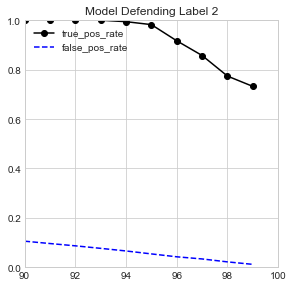

In [38]:
plot_pos_rates(plot_data, [label])

-------------

For the sake of completeness, all models from both groups are evaluted on rotationally robust adversarial examples.

-------------

In [39]:
labels = [2, 3, 5, 7]
plot_data = {}
rot_amt = (-1 * np.pi / 2, np.pi / 2)

for label in labels:
    model, pattern, mask = models_basic[label]
    sig, feature_extractor, thresholds = setup_backdoor_defense(label, model,
                                                                pattern, mask,
                                                                test_images,
                                                                train_images,
                                                                raw_train_labels)
    rot_layer = RandomRotation(rot_amt, fill_mode='constant', interpolation='nearest')
#     non_label_mask = raw_test_labels != label
#     non_label_test = test_images[np.squeeze(non_label_mask, axis=1)]
#     rot_adv_imgs, rot_adv_loss = transform_robust_targeted_PGD(model, non_label_test, label, 200, rot_layer, steps=500,
#                                                    alpha=0.0008, eps=0.03, num_aug_imgs=10)
    
    fp = 'cifar10_hp_nonoise/label'+str(label)+'noise0.0/attacks/rotRobust/'
#     if not os.path.exists(fp):
#         os.makedirs(fp)
#     np.save(fp + 'imgs', rot_adv_imgs)
#     np.save(fp + 'loss', rot_adv_loss)
    
    rot_adv_imgs = np.load(fp + 'imgs.npy')
    rot_adv_loss = np.load(fp + 'loss.npy')
    
    plot_data[label] = test_backdoor_defense(rot_adv_imgs, test_images, label, feature_extractor, sig, thresholds)

<Figure size 432x288 with 0 Axes>

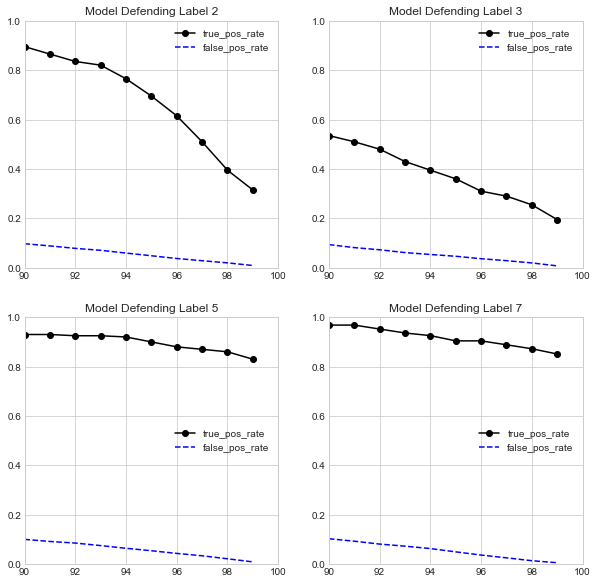

In [40]:
plot_pos_rates(plot_data, labels)

In [41]:
labels = [2, 3, 5, 7]
plot_data = {}

for label in labels:
    model, pattern, mask = models_botRight[label]
    sig, feature_extractor, thresholds = setup_backdoor_defense(label, model,
                                                                pattern, mask,
                                                                test_images,
                                                                train_images,
                                                                raw_train_labels)
    rot_layer = RandomRotation(rot_amt, fill_mode='constant', interpolation='nearest')
#     non_label_mask = raw_test_labels != label
#     non_label_test = test_images[np.squeeze(non_label_mask, axis=1)]
#     rot_adv_imgs, rot_adv_loss = transform_robust_targeted_PGD(model, non_label_test, label, 200, rot_layer, steps=500,
#                                                    alpha=0.0008, eps=0.03, num_aug_imgs=10)
    
    fp = 'cifar10_hp_nonoise/label'+str(label)+'noise0.0bottomRight/attacks/rotRobust/'
    
#     if not os.path.exists(fp):
#         os.makedirs(fp)
#     np.save(fp + 'imgs', rot_adv_imgs)
#     np.save(fp + 'loss', rot_adv_loss)
    
    rot_adv_imgs = np.load(fp + 'imgs.npy')
    rot_adv_loss = np.load(fp + 'loss.npy')
    
    plot_data[label] = test_backdoor_defense(rot_adv_imgs, test_images, label, feature_extractor, sig, thresholds)

<Figure size 432x288 with 0 Axes>

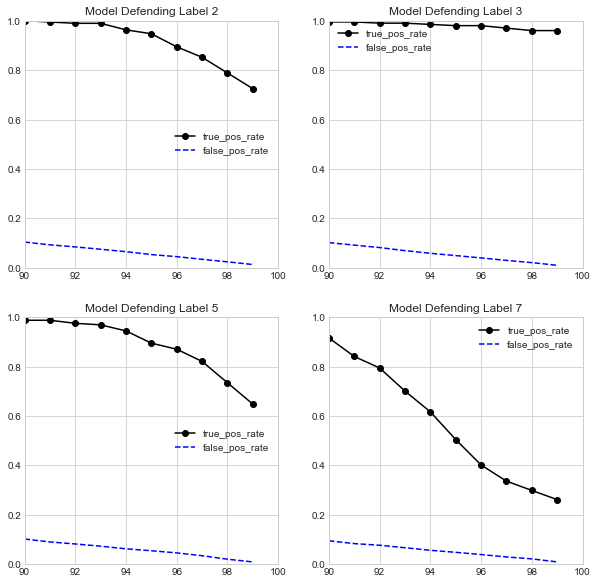

In [42]:
plot_pos_rates(plot_data, labels)

### Ongoing and Future Work

##### Trigger Placement
I had not anticipated the effect that trigger placement would have on the method.  I'm trying other work to understand this more clearly:

1) Testing effects of trigger placement on a grid across all labels to get a clearer sense of how detection accuracy changes due to placement.

2) Try the same thing with other datasets to see how much variance in this effect exists between datasets

3) Try building triggers out of multiple patches to see whether and to what degree this smoothes the behavior of the detection method

4) Place multiple triggers in different locations and use an ensembling method for detection

